In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Define constants
DATA_DIR = "train_image"
LABELS_FILE = "train.csv"
BATCH_SIZE = 32

# Load labels
df = pd.read_csv(LABELS_FILE)
df["file_path"] = df["Id"].apply(lambda x: os.path.join(DATA_DIR, f"{x}.jpg"))

# Function for smart resizing with padding (dynamic loading)
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to [0,1]

    # Resize dynamically but keep aspect ratio using padding
    img = tf.image.resize_with_pad(img, target_height=256, target_width=256)

    return img, tf.cast(label, tf.float32)

# ✅ Create a TensorFlow Dataset for Efficient Loading (No Memory Overflow)
dataset = tf.data.Dataset.from_tensor_slices((df["file_path"].values, df["Pawpularity"].values))
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# ✅ Split Dataset: 70% Train, 15% Validation, 15% Test
DATASET_SIZE = len(df)
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)

train_dataset = dataset.take(train_size).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = dataset.skip(train_size).take(val_size).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = dataset.skip(train_size + val_size).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

print(f"Train dataset: {train_size} samples")
print(f"Validation dataset: {val_size} samples")
print(f"Test dataset: {DATASET_SIZE - train_size - val_size} samples")

Train dataset: 6938 samples
Validation dataset: 1486 samples
Test dataset: 1488 samples


In [4]:
# Implement Data Augmentation on-the-fly (No RAM Usage)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# 🔹 Define the CNN Model with Global Average Pooling
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(None, None, 3)),  # Accepts variable input sizes

    # First Convolutional Block
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Fourth Convolutional Block
    layers.Conv2D(filters=128, kernel_size=(7, 7), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Global Average Pooling (Handles Variable Input Sizes)
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(1, activation='linear')  # Regression output
])

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Show model summary
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, None, None, 16) │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, None, None, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, None, None, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, None, None, 32) │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, None, None, 64) │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, None, None,     │       401,536 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,169 (1.78 MB)

 Trainable params: 466,689 (1.78 MB)

 Non-trainable params: 480 (1.88 KB)

In [5]:
# Train the Model with Augmented Data
import time

class PrintLoss(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        t = time.monotonic() - self.time
        print('| Epoch {:2} | Time {:6.2f}s | Train Loss {:.4f} | Val Loss {:.4f} |'
              .format(epoch, t, logs['loss'], logs['val_loss']))

    def on_epoch_begin(self, epoch, logs):
        if epoch == 0:
            self.time = time.monotonic()

# Training Parameters
EPOCHS = 50

# Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, PrintLoss()]
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - loss: 865.9227 - mae: 22.4623| Epoch  0 | Time 190.76s | Train Loss 628.2662 | Val Loss 411.3354 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 191s 870ms/step - loss: 864.8325 - mae: 22.4450 - val_loss: 411.3354 - val_mae: 15.0724
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - loss: 503.4643 - mae: 16.5519| Epoch  1 | Time 409.73s | Train Loss 490.9144 | Val Loss 426.6809 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - loss: 503.4068 - mae: 16.5512 - val_loss: 426.6809 - val_mae: 16.2396
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - loss: 493.3349 - mae: 16.5084| Epoch  2 | Time 633.07s | Train Loss 485.8203 | Val Loss 432.5754 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - loss: 493.3004 - mae: 16.5080 - val_loss: 432.5754 - val_mae: 15.2074
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - loss: 484.5106 - mae: 16.5289| Epoch  3 | Time 862.03s | Train Loss 478.8736 | Val Loss 439.8646 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 373s 2

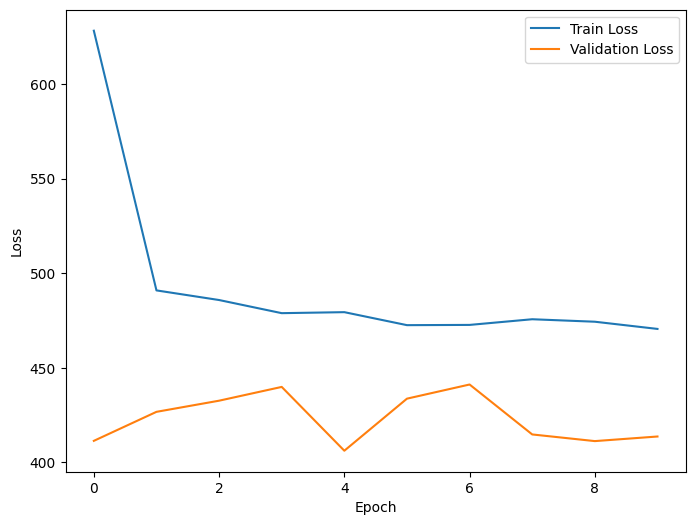

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label="Train Loss")
    plt.plot(hist['epoch'], hist['val_loss'], label="Validation Loss")
    plt.legend()
    plt.show()

# Plot the training history
plot_history(history)

In [7]:
# Evaluate model performance on test dataset
loss, mae = model.evaluate(test_dataset)

print(f"Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {loss:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - loss: 425.7993 - mae: 15.2836
Model Performance on Test Set:
Mean Squared Error (MSE): 414.4189
Mean Absolute Error (MAE): 15.1713


In [10]:
# Predict Pawpularity scores on test set
y_pred = model.predict(test_dataset).flatten()  # Predict directly from test dataset

# Extract actual labels from test dataset
y_test = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)  # Convert dataset labels to NumPy array

# Compare first 10 predictions
for i in range(10):
    print(f"Actual: {y_test[i]:.2f}, Predicted: {y_pred[i]:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step
Actual: 38.00, Predicted: 39.96
Actual: 57.00, Predicted: 38.96
Actual: 33.00, Predicted: 36.51
Actual: 40.00, Predicted: 32.45
Actual: 34.00, Predicted: 39.78
Actual: 15.00, Predicted: 39.73
Actual: 7.00, Predicted: 36.84
Actual: 27.00, Predicted: 39.43
Actual: 57.00, Predicted: 41.64
Actual: 36.00, Predicted: 34.21


2025-02-23 01:24:05.997378: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


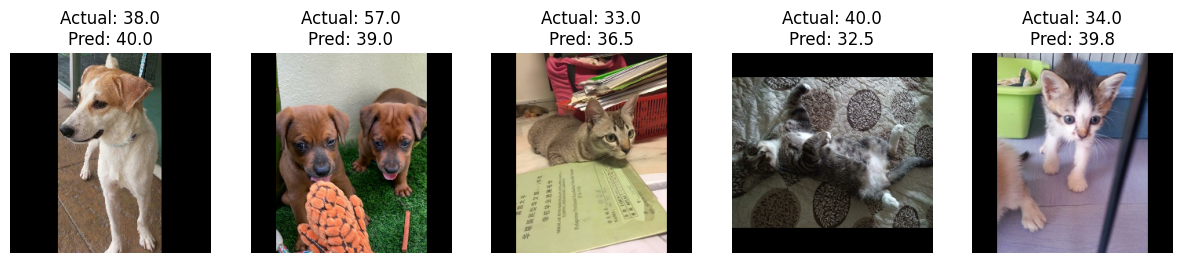

In [11]:
import matplotlib.pyplot as plt

# Extract first 5 images and labels from test_dataset
X_test_samples, y_test_samples = next(iter(test_dataset.take(1)))  # Take one batch

# Convert predictions
y_pred_samples = model.predict(X_test_samples).flatten()

# Show images with actual vs predicted scores
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test_samples[i].numpy())  # Convert Tensor to NumPy
    ax.set_title(f"Actual: {y_test_samples[i].numpy():.1f}\nPred: {y_pred_samples[i]:.1f}")
    ax.axis("off")

plt.show()

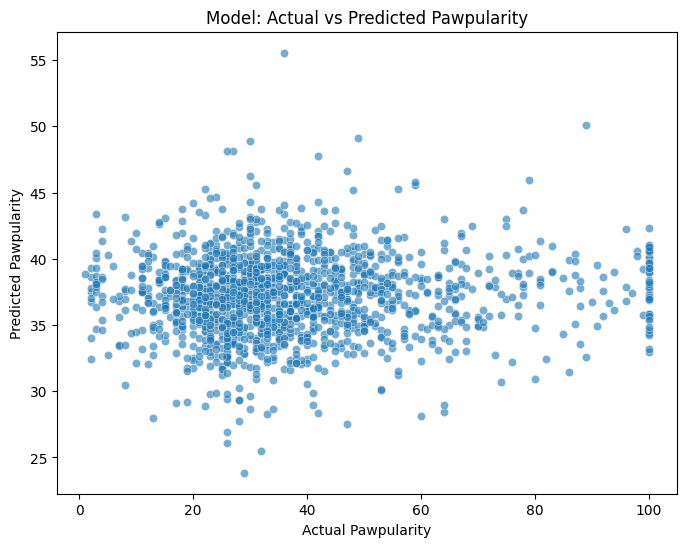

In [12]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("Model: Actual vs Predicted Pawpularity")
plt.show()